In [89]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
import pandas as pd
# pearson correlation
from scipy.stats import pearsonr
import sklearn.decomposition as skd 


In [2]:
# Download data from https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2/new/ 
# select file sst.oisst.mon.mean.1982.nc

fnom = xr.open_dataset('sst.oisst.mon.mean.1982.nc',decode_times=False)
fnom


<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 499)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) float64 6.647e+04 6.65e+04 6.653e+04 ... 8.16e+04 8.163e+04
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:            Climate Data Interface version 1.9.10 (https://mpimet.mpg...
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    institution:    NOAA/National Centers for Environmental Information
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...
    CDO:            Climate Data Operators version 1.9.10 (https://mpimet.mpg...
    history:        Tue Aug  8 15:12:26 2023: ncks -d time,4, /scratch/csmith...
    NCO:            netCDF Operators version 4.8.1 (Homepage = http://nco.sf....

In [70]:
ax_y = pd.date_range('1982-01-01','2022-12-31',freq='M')

In [22]:
sst = fnom.sst.values[0:492]
tsteps, nlat, nlon = np.int16(sst.shape)
nyear = np.int16(tsteps/12)
print(nyear,tsteps,nlat,nlon)

41 492 180 360


# Vizualize your data

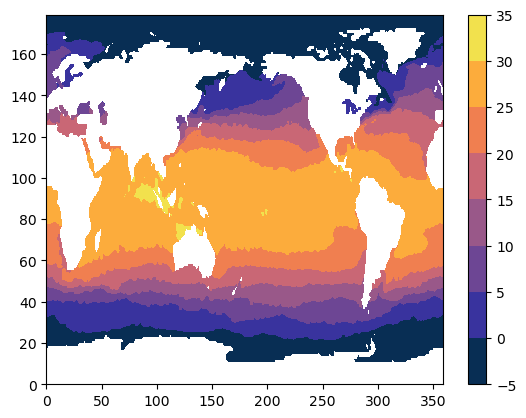

In [23]:
# array for matplotlib
plt.figure()
plt.contourf(sst[123],cmap=cm.cm.thermal)
plt.colorbar()

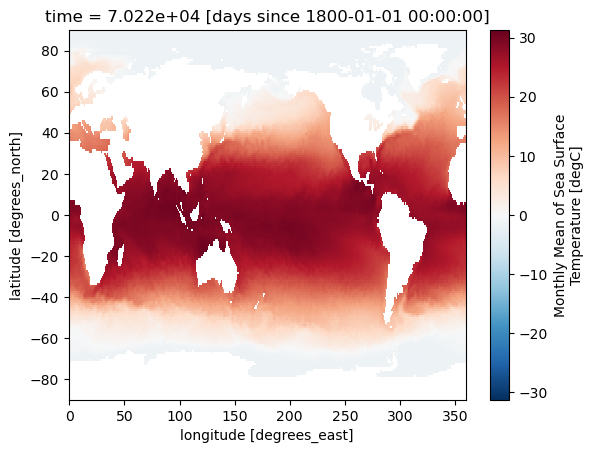

In [24]:
# data array used by xarray
fnom.sst[123].plot()

In [25]:
#sst_ann = fnom.sst.isel(time = np.arange(0,492),lat = np.arange(0,180),lon=np.arange(0,360))

sst_ann = fnom.sst.values[0:492,:,:].reshape(41,12,nlat,nlon).mean(axis=1)
print(sst_ann.shape)
sst_ann = xr.DataArray(sst_ann)
#sst_ann

(41, 180, 360)


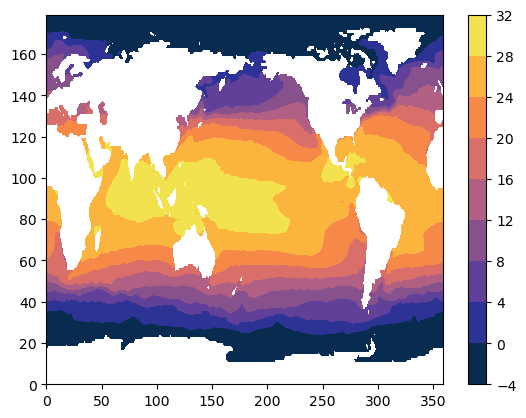

In [26]:
plt.figure()
plt.contourf(sst_ann[20],cmap=cm.cm.thermal)
plt.colorbar()

(12, 180, 360)
(492, 180, 360)


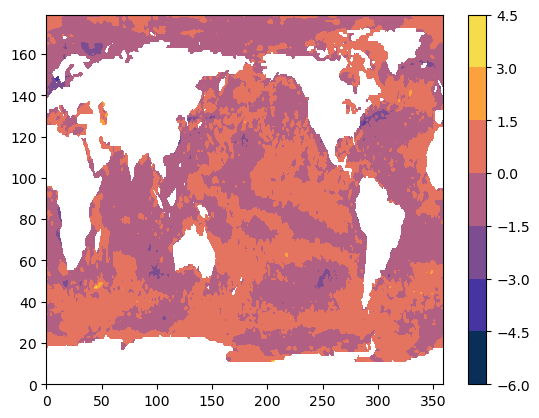

In [39]:
# monthly anomalies

#monthly climatology
sst_mon_clim = fnom.sst.values[0:492,:,:].reshape(41,12,nlat,nlon).mean(axis=0)
print(sst_mon_clim.shape)


# get monthly anomalies

sst_anom = (sst.reshape([nyear,12,nlat,nlon]) - sst_mon_clim).reshape(nyear*12,nlat,nlon)
print(sst_anom.shape)
plt.figure()
plt.contourf(sst_anom[0],cmap=cm.cm.thermal)
plt.colorbar()


/Users/prajvalakurtakoti/anaconda3/envs/prajvala_oldNERSC_CMIP6_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


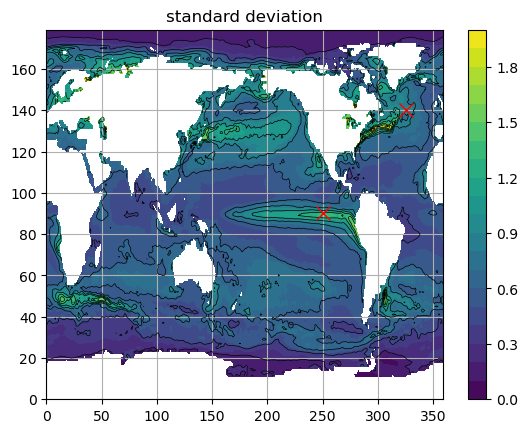

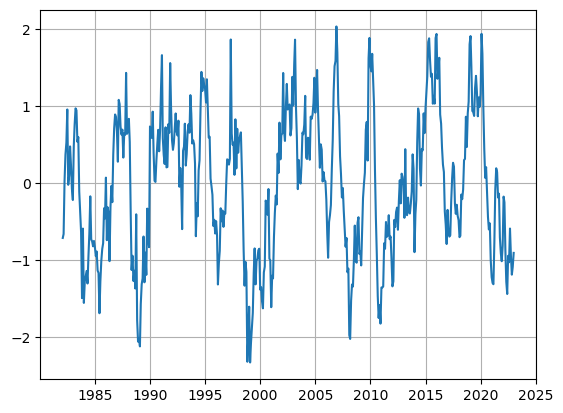

In [71]:
plt.figure()
CS = plt.contourf(np.nanstd(sst_anom,axis=0),np.linspace(0,2,21))
plt.contour(CS, levels=CS.levels[::2], colors='k',linewidths=0.5)
plt.colorbar(CS)
plt.plot([250,325],[90,140],'rx',ms=10)
plt.title("standard deviation")
plt.grid()
time =np.arange(1982,2)
plt.figure()
plt.plot(ax_y,sst_anom[:,90,180])
plt.grid()


PearsonRResult(statistic=-0.1625335315987565, pvalue=0.0002944925312633449)


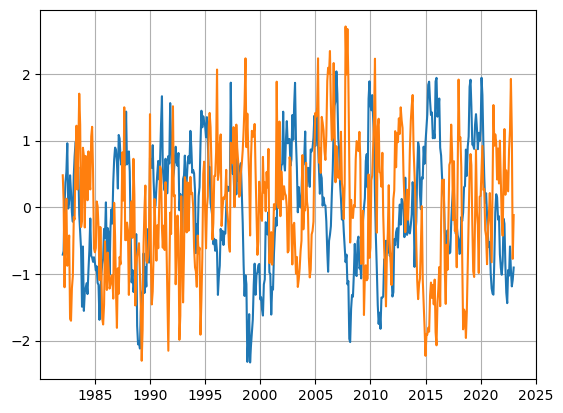

In [76]:
# plot timeseries of 2 points in pacific and atlantic
plt.figure()
plt.plot(ax_y,sst_anom[:,90,180])
plt.plot(ax_y,sst_anom[:,140,325])
plt.grid()

print(pearsonr(sst_anom[:,90,180],sst_anom[:,140,325]))

(492, 45153)


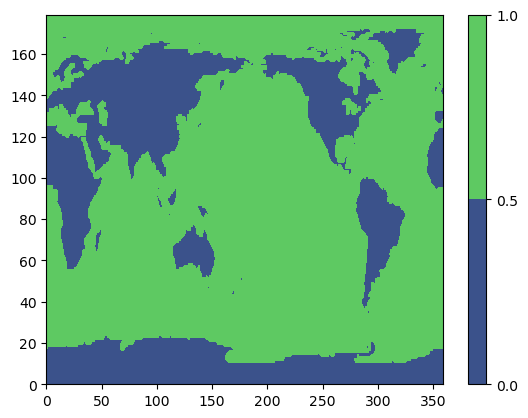

In [93]:
# create landmask
omask = ~np.isnan(sst[10])
plt.figure()
plt.contourf(omask)
plt.colorbar()

print(sst[:,omask].shape)

(492, 10)


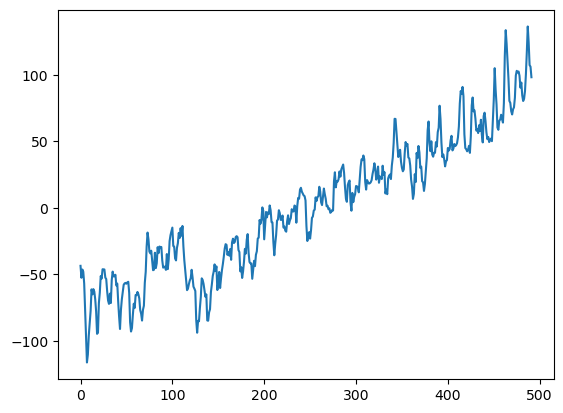

In [160]:
# SVD example
pca = skd.PCA(n_components=10)
emp_pca = pca.fit_transform(sst_anom[:,omask])
print(emp_pca.shape)
sst_pc_ts= emp_pca

plt.figure()
plt.plot(sst_pc_ts[:,0])

In [161]:
V = np.ones([10,nlat,nlon])*np.nan
V[:,omask]=pca.components_
V.shape

(10, 180, 360)

In [212]:
ncomp = 1
print(sst_pc_ts[:,0].shape,pca.components_[0].shape)
print(sst_pc_ts[:,0].reshape([-1,1]).shape,pca.components_[0].reshape([1,-1]).shape)
print((sst_pc_ts[:,0].reshape([-1,1])@pca.components_[0].reshape([1,-1])).shape)
X_new = np.ones([492,nlat,nlon])
X_new[:,omask] = sst_pc_ts[:,:ncomp].reshape([-1,ncomp])@pca.components_[:ncomp].reshape([ncomp,-1]) + pca.mean_

(492,) (45153,)
(492, 1) (1, 45153)
(492, 45153)


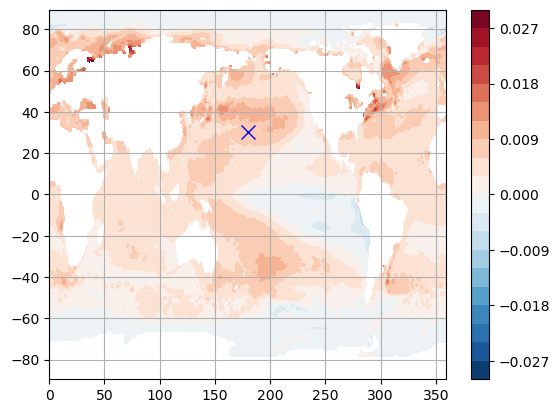

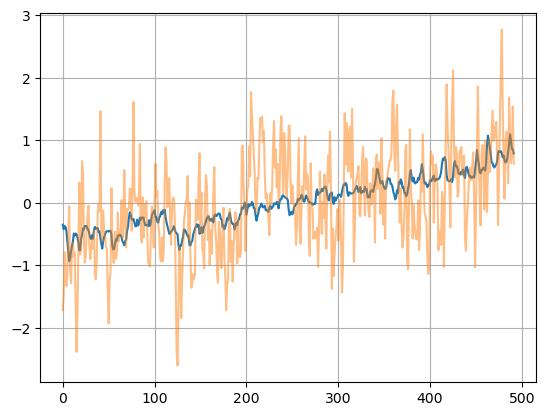

In [217]:
lon2d,lat2d = np.meshgrid(fnom.lon.values,fnom.lat.values)
plt.figure()
plt.contourf(lon2d,lat2d,V[0],np.linspace(-.03,.03,21),cmap='RdBu_r')
plt.colorbar()
plt.plot(fnom.lon[180],fnom.lat[120],'bx',ms=10)
plt.grid()

plt.figure()
plt.plot(X_new[:,120,180])
plt.plot(sst_anom[:,120,180],alpha=.5)
plt.grid()

#X @ self.components_ + self.mean_

In [218]:
print("% explained variance: ",100.*pca.explained_variance_ratio_)
sst_eofs = pca.components_
sst_var=100.*pca.explained_variance_ratio_


% explained variance:  [14.637931   9.077624   3.760673   2.5194678  2.3660376  2.1401987
  1.9791431  1.7974516  1.6025374  1.5002197]
